In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [3]:
import optax

In [4]:
class MMD:

    def __init__(self, scales, space):
        gammas = 1 / (2 * (scales**2))
        sq_dists = jnp.abs(space[:, None] - space[None, :]) ** 2
        self.K = sum(jnp.exp(-gamma * sq_dists) for gamma in gammas) / len(scales)
        self.scales = scales

    def k_expval(self, px, py):
        # Kernel expectation value
        return px @ self.K @ py

    def __call__(self, px, py):
        pxy = px - py
        return self.k_expval(pxy, pxy)

In [5]:
from functools import partial

class QCBM:

    def __init__(self, circ, mmd, py):
        self.circ = circ
        self.mmd = mmd
        self.py = py  # target distribution π(x)

    @partial(jax.jit, static_argnums=0)
    def mmd_loss(self, params):
        px = self.circ(params)
        return self.mmd(px, self.py), px

In [6]:
@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
    return params, opt_state, loss_val, kl_div

## Mixture of Gaussains

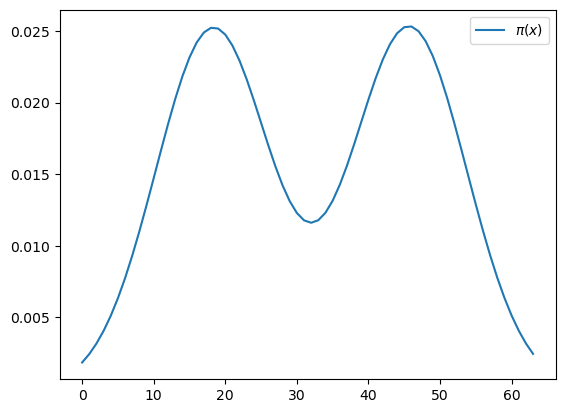

In [7]:
def mixture_gaussian_pdf(x, mus, sigmas):
    mus, sigmas = np.array(mus), np.array(sigmas)
    vars = sigmas**2
    values = [
        (1 / np.sqrt(2 * np.pi * v)) * np.exp(-((x - m) ** 2) / (2 * v)) for m, v in zip(mus, vars)
    ]
    values = np.sum([val / sum(val) for val in values], axis=0)
    return values / np.sum(values)


n_qubits = 6
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(2 / 7) * x_max, (5 / 7) * x_max]
sigmas = [x_max / 8] * 2
data = mixture_gaussian_pdf(x_input, mus, sigmas)

plt.plot(data, label=r"$\pi(x)$")
plt.legend()
plt.show()

## Noise Model Quantum Computer

In [8]:
n_layers = 4
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)


def circuit(weights):
    qml.StronglyEntanglingLayers(
        weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
    )
    return qml.probs()

In [9]:
# Describe noise model
fcond = qml.noise.wires_in(range(n_qubits))
noise = qml.noise.partial_wires(qml.PhaseDamping, 0.1)
noise_model = qml.NoiseModel({fcond: noise})

# Load devices
dev_ideal = qml.device("default.mixed", wires = n_qubits)
dev_noisy = qml.add_noise(dev_ideal, noise_model = noise_model)

In [10]:
ideal_qnode = qml.QNode(circuit, dev_ideal)
noisy_qnode = qml.QNode(circuit, dev_noisy)
#noisy_qnode = qml.transforms.decompose(noisy_qnode, gate_set = ["RY", "CZ"])

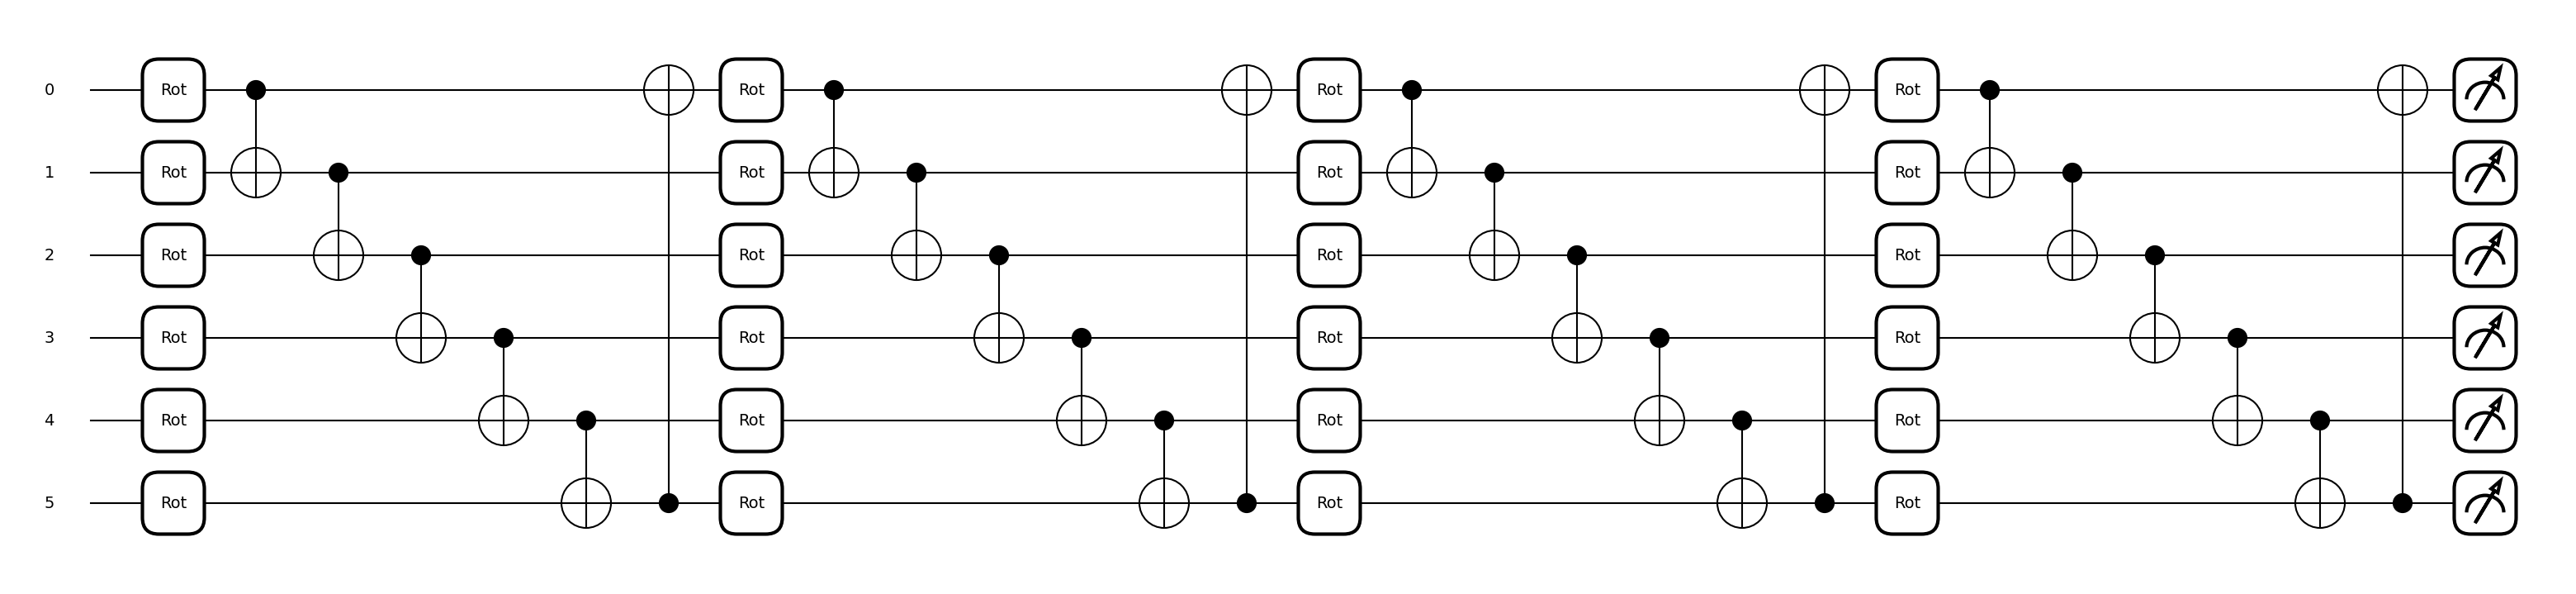

In [11]:
qml.draw_mpl(qml.QNode(circuit, dev_ideal), level="device")(weights)
plt.show()

In [12]:
jit_circuit = jax.jit(noisy_qnode)

In [13]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 1000

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

# Want to plot 

Step: 0 Loss: 0.0233 KL-div: 0.6234
Step: 10 Loss: 0.0019 KL-div: 0.1314
Step: 20 Loss: 0.0012 KL-div: 0.0851
Step: 30 Loss: 0.0007 KL-div: 0.0482
Step: 40 Loss: 0.0005 KL-div: 0.0372
Step: 50 Loss: 0.0004 KL-div: 0.0302
Step: 60 Loss: 0.0003 KL-div: 0.0250
Step: 70 Loss: 0.0002 KL-div: 0.0220
Step: 80 Loss: 0.0002 KL-div: 0.0197
Step: 90 Loss: 0.0002 KL-div: 0.0171
Step: 100 Loss: 0.0001 KL-div: 0.0154
Step: 110 Loss: 0.0001 KL-div: 0.0143
Step: 120 Loss: 0.0001 KL-div: 0.0135
Step: 130 Loss: 0.0001 KL-div: 0.0129
Step: 140 Loss: 0.0001 KL-div: 0.0124
Step: 150 Loss: 0.0001 KL-div: 0.0119
Step: 160 Loss: 0.0001 KL-div: 0.0116
Step: 170 Loss: 0.0001 KL-div: 0.0113
Step: 180 Loss: 0.0001 KL-div: 0.0111
Step: 190 Loss: 0.0001 KL-div: 0.0109
Step: 200 Loss: 0.0001 KL-div: 0.0107
Step: 210 Loss: 0.0001 KL-div: 0.0105
Step: 220 Loss: 0.0001 KL-div: 0.0103
Step: 230 Loss: 0.0001 KL-div: 0.0101
Step: 240 Loss: 0.0001 KL-div: 0.0099
Step: 250 Loss: 0.0001 KL-div: 0.0096
Step: 260 Loss: 0.0001 

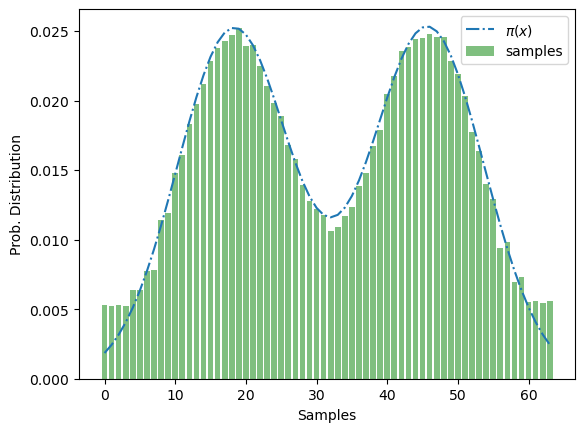

In [14]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()